In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
#for reporducibilty
np.random.seed(42)

In [2]:
#Read data
life_expectancy_df = pd.read_csv("Cleaned_data/Life Expectancy Data.csv")

We want to see the trends and differences in immunization coverage behaviours between developed and developing countries.

In [4]:
developed_countries_df = life_expectancy_df[life_expectancy_df["Status"] == "Developed"]
developing_countries_df = life_expectancy_df[life_expectancy_df["Status"] == "Developing"]

Divide each dataframe made above by year

In [5]:
developing_df_by_year ={}
years = developing_countries_df.Year.unique()
for year in years:
    developing_df_by_year[str(year)] = developing_countries_df[developing_countries_df["Year"]==year]

In [6]:
developed_df_by_year ={}
years = developed_countries_df.Year.unique()
for year in years:
    developed_df_by_year[str(year)] = developed_countries_df[developed_countries_df["Year"]==year]

##### Helper functions
Draw distribution of any variable

In [7]:
#Freedman rule is a statistical rule that infers the most suitable bin width for a variable based on the IQR 
def FreedmanRule(input_vector):
    #calculate IQR
    #print(input_vector)
    #using nan percentile to ignore nans
    q75, q25 = np.nanpercentile(input_vector, [75 ,25])
    #print(q25)
    iqr = q75 - q25
    #calculate Bin width
    bin_width = (2* iqr) / int(round(len(input_vector) ** (1. / 3)))
    return bin_width

In [8]:
#Draw the distribution
def drawDist(variable_to_display, title):
    bin_width = FreedmanRule(variable_to_display)
    num_bins = math.ceil((variable_to_display.max() - variable_to_display.min())/bin_width)
    ax = variable_to_display.plot.hist(bins=num_bins, alpha=0.5)
    ax.set_title(title)
    

#### Lets consider developed countries and developing countries distribution

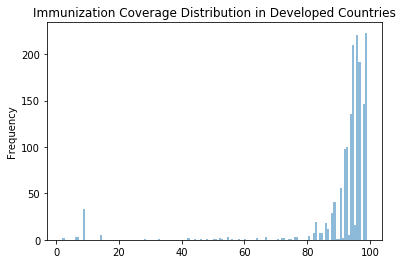

In [9]:
drawDist(developed_countries_df["Immunization coverage"], "Immunization Coverage Distribution in Developed Countries")

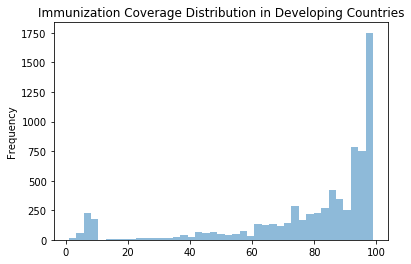

In [10]:
drawDist(developing_countries_df["Immunization coverage"], "Immunization Coverage Distribution in Developing Countries")

The immunization coverage has a skewed distribution in both developed and developing countries. Therefore, we can take the median to be representative of it.

In [11]:
#input: status and feature, output: array that contains median of the given feature for the developed/developing countries 
def median_by_status(status, feature):
    if(status =="Developing"):
        dataframe_of_interest = developing_df_by_year
    else:
        dataframe_of_interest = developed_df_by_year
    median_of_countries =[]
    
    for year in life_expectancy_df.Year.unique():
        median_of_countries.append(dataframe_of_interest[str(year)][feature].median())
        
    return median_of_countries

In [12]:
immunization_developed_countries = median_by_status("Developed", "Immunization coverage")
immunization_developing_countries = median_by_status("Developing", "Immunization coverage")


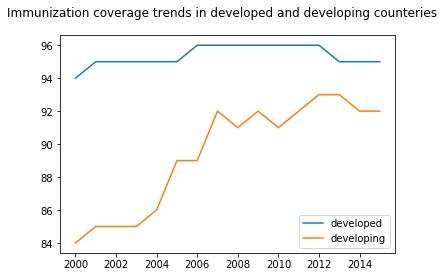

In [13]:
fig, ax = plt.subplots()
ax.plot(developed_countries_df.Year.unique(), immunization_developed_countries, label ="developed")
ax.plot(developing_countries_df.Year.unique(), immunization_developing_countries, label = "developing")
plt.suptitle("Immunization coverage trends in developed and developing counteries")
leg = ax.legend();
plt.show()

##### insight
As we can see, there is an increasing trend in immunization coverage in developing countries as we are progressing through the years. The increase rate is very apparent during the years 2002 onwards and is stabilising. 

However developed countries have started off very high already, there is not much growth and the coverage has stabilised around 95% immunization coverage. It is apparent that developing countries are still struggling to get vaccines to those who need it however vaccines are more available in developed countries.

Lets look at what are the most diseases that countries try to immunise the most against. Below we compute the median coverage for each disease throughout the years and plot a stacked bar where each bar is divided to represent the 3 diseases.

In [14]:
#input: status I want to investigate
#outut:dictionary of diseases, Each dict entry contains an array in the form [coverage of disease at year i,coverage of disease at year i+1...] ]
def disease_statistics(status):
    df_disease_by_year={}
    if(status == "Developing"):
        dict_of_interest = developing_df_by_year
    else:
        dict_of_interest = developed_df_by_year
        
    for disease in life_expectancy_df.Disease.unique():
        temp_array=[]#holds temporary values of median by disease
        for year in life_expectancy_df.Year.unique():
            temp_array.append(dict_of_interest[str(year)].groupby(["Disease"])["Immunization coverage"].median()[disease])
        df_disease_by_year[str(disease)] = temp_array
    return df_disease_by_year

Below is a helper function to plot a stacked bar. The offsets array tells matplotlib which bar is ontop of the other to prevent overlaps.

In [15]:
def plot_stacked(X,Y, offsets_array, xlabel,ylabel, labels,title):
    fig, ax = plt.subplots()
    width =0.35

    for i in range(0, len(Y)):
        ax.bar(X, Y[i], width, label=labels[i], bottom =offsets_array[i])
        
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    plt.show()
    

Initialising variables for the plot_stacked method.

In [16]:
developing_df_disease_by_year= disease_statistics("Developing")
developed_df_disease_by_year= disease_statistics("Developed")

labels = life_expectancy_df.Year.unique()
labels_array =["polio", "Diphtheria", "Hepatitis B"]

bar_values_developing = [developing_df_disease_by_year["Polio"],developing_df_disease_by_year["Diphtheria"],developing_df_disease_by_year["Hepatitis B"]]
bar_values_developed = [developed_df_disease_by_year["Polio"],developed_df_disease_by_year["Diphtheria"],developed_df_disease_by_year["Hepatitis B"]]

bottom_offset_developing = np.array(developing_df_disease_by_year["Diphtheria"]) +np.array(developing_df_disease_by_year["Hepatitis B"])
bottom_offset_developed = np.array(developed_df_disease_by_year["Diphtheria"]) +np.array(developed_df_disease_by_year["Hepatitis B"])

offsets_array_developing =[bottom_offset_developing,developing_df_disease_by_year["Hepatitis B"],0 ]
offsets_array_developed =[bottom_offset_developed,developed_df_disease_by_year["Hepatitis B"],0 ]

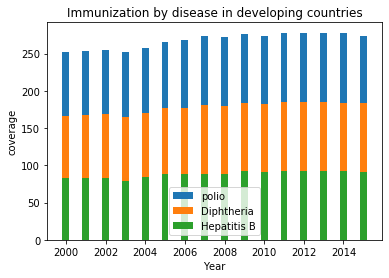

In [17]:
plot_stacked(labels,bar_values_developing,offsets_array_developing, "Year", "coverage", labels_array,"Immunization by disease in developing countries")

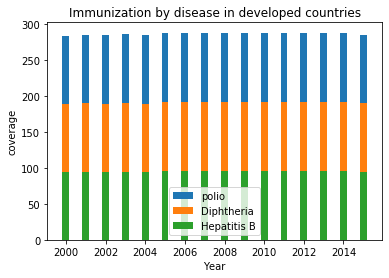

In [18]:
plot_stacked(labels,bar_values_developed,offsets_array_developed, "Year", "coverage",labels_array, "Immunization by disease in developed countries")

##### insight
In developed countries, Hepatitis B and Diphtheria are almost the same throughout all years, however Polio immunization coverage is fluctuating in the beginning then it stablises towards the last 3 years. However in developing countries the immunization coverage is fluctuating and began to stay the same from year 2012 onwards. Judging visually, it seems that developing and developed countries do not favour a disease over the other but all 3 are roughly given equal coverage.  

Why is it that immunization is lower in developing countries than developed countries? Lets explore the factors that affect the growth of immunization coverage in developing countries. We explore GDP and life expectancy. First, if we want to get a value that could represent developed countries GDP and life expectancy during the years, lets draw the distribution of GDP and life expectancy.

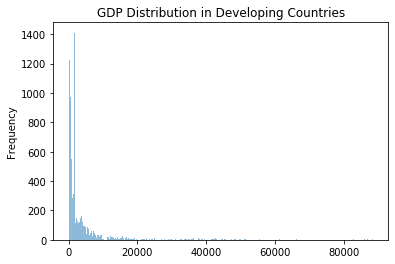

In [19]:
drawDist(developing_countries_df["GDP"], "GDP Distribution in Developing Countries")

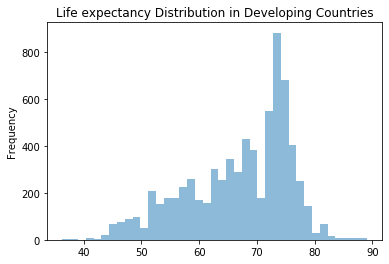

In [20]:
drawDist(developing_countries_df["Life expectancy"], "Life expectancy Distribution in Developing Countries")

The distribution of both GDP and life expectancy is skewed, thus making the median a good representative.

In [21]:
#get array in the form [x1, x2...] where x is the median value of the variable at year x
gdp_developing = median_by_status("Developing", "GDP")
life_exp_developing = median_by_status("Developing", "Life expectancy")

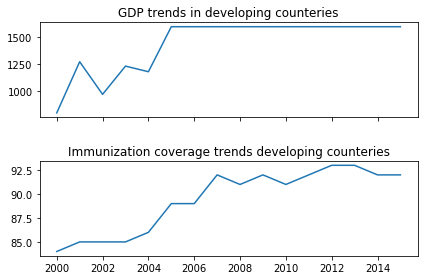

In [22]:
fig, ax = plt.subplots(2)
ax[0].plot(developing_countries_df.Year.unique(), gdp_developing)
ax[1].plot(developing_countries_df.Year.unique(),immunization_developing_countries)
#ax[2].plot(developing_countries_df.Year.unique(),life_exp_developing)
ax[0].set_title("GDP trends in developing counteries")
ax[1].set_title("Immunization coverage trends developing counteries")
#ax[2].set_title("Life expectancy trends developing counteries")
plt.tight_layout()
for a in ax.flat:
    a.label_outer()
plt.show()

GDP is the gross domestic product, it is usually an indicator of the strength of a country's economy. A higher GDP usually means high production and a stronger economy. Apparently the GDP of a country has to be at a certain minimum in order for immunization coverage to be able to grow. If we take a look at 2000-2001 we see a growth in GDP which is mirrored by a growth in immunization coverage. After that there is a dip in GDP, which reflects in a plateau in coverage. As soon as GDP starts growing again we notice a growth in immunization as well. Subsequently, as the GDP starts to stabilise, immunization coverage starts to grow. There is a slight dip in 2009 in immunization. This can be considered strange but after looking further into it, we found that in 2009 the H1N1 (commonly known as swine flu) has outbreaked and was later deemed a pandemic. This might have impacted vaccine production or general public access to vaccines. As we can see towards the end as GDP stabilises immunity coverage starts to stabilise too and we should be expecting a growth if no unexpected external events happen.

#### but is immunization worthwhile ?
Do developing countries need to focus on immunization?

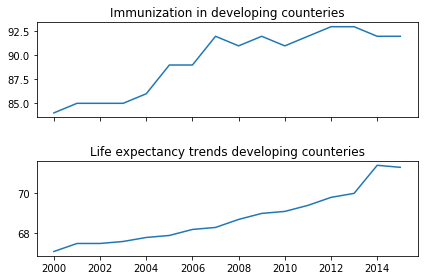

In [23]:
fig, ax = plt.subplots(2)
ax[0].plot(developing_countries_df.Year.unique(), immunization_developing_countries)
ax[1].plot(developing_countries_df.Year.unique(),life_exp_developing)
ax[0].set_title("Immunization in developing counteries")
ax[1].set_title("Life expectancy trends developing counteries")
plt.tight_layout()
for a in ax.flat:
    a.label_outer()
plt.show()

As  we can see life expectancy grows with immunization. Greater coverage leads to a longer life expectancy which is a general indicator of good health. Therefore immunization coverage is important to focus on for developing countries